# Librerias

In [34]:
import pandas as pd
import numpy as np

## Librerias para graficación
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

## Lectura del dataset

In [35]:
# Descargar archivos parquet y guardarlos localmente
# !python -m wget "https://huggingface.co/api/datasets/amazon_us_reviews/parquet/Video_Games_v1_00/train/0.parquet" -o 0.parquet
# !python -m wget "https://huggingface.co/api/datasets/amazon_us_reviews/parquet/Video_Games_v1_00/train/1.parquet" -o 1.parquet
# !python -m wget "https://huggingface.co/api/datasets/amazon_us_reviews/parquet/Video_Games_v1_00/train/2.parquet" -o 2.parquet

In [36]:
df0 = pd.read_parquet("0.parquet")
df1 = pd.read_parquet("1.parquet")
df2 = pd.read_parquet("2.parquet")

In [37]:
df = pd.concat([df0, df1, df2], axis=0)

C:\Users\pms_l\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(9.444444444444445, 0.5, 'Conteo')

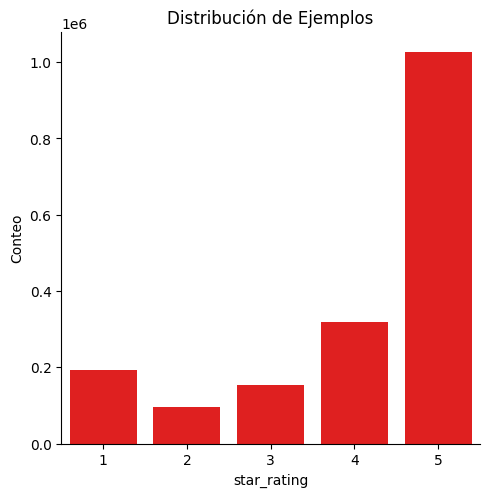

In [38]:
sns.catplot(x='star_rating', kind='count', color='r', data=df)
plt.title('Distribución de Ejemplos')
plt.xlabel('star_rating')
plt.ylabel('Conteo')

## Sample del dataset

In [39]:
def balancear_dataset_por_rating(data_frame):
    # Obtenemos el recuento de cada valor de "rating"
    conteo_ratings = data_frame['star_rating'].value_counts()

    # Obtenemos el mínimo de ocurrencias de "rating" que queremos mantener
    min_ocurrencias = min(conteo_ratings)

    # Filtramos las filas que tienen "rating" mayor o igual al mínimo especificado
    data_frame_balanceado = data_frame.groupby('star_rating').apply(lambda x: x.sample(min_ocurrencias, random_state=42))

    # Restablecemos el índice del DataFrame resultante y eliminamos el índice antiguo
    data_frame_balanceado.reset_index(drop=True, inplace=True)

    return data_frame_balanceado

In [40]:
df.shape

(1785997, 15)

In [41]:
df_balanceado = balancear_dataset_por_rating(df)

In [42]:
df_train = df_balanceado.copy()
df_train['text'] = df_train['review_headline'] + ' ' + df_train['review_body']

In [43]:
# Se obtiene una muestra del dataset
df_train = df_train.sample(250000,random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_train = df_train[["text", "star_rating"]]

C:\Users\pms_l\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-12.430555555555555, 0.5, 'Conteo')

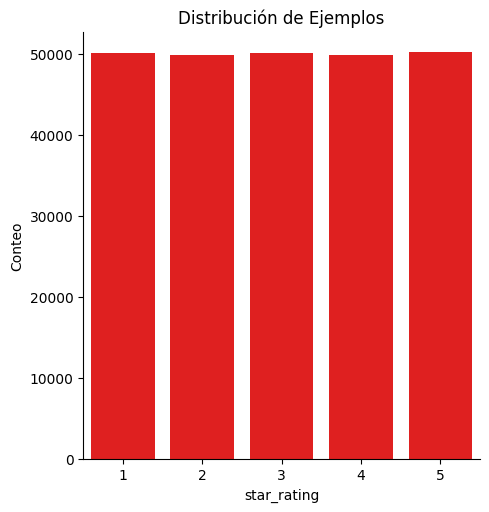

In [44]:
sns.catplot(x='star_rating', kind='count', color='r', data=df_train)
plt.title('Distribución de Ejemplos')
plt.xlabel('star_rating')
plt.ylabel('Conteo')

# Modelamiento por Arquitecturas

## BOW

In [45]:
import re
import nltk
from nltk.corpus import stopwords

stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pms_l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
def processing_text(texto):
    # Paso 1: Remover con un expresión regular carateres especiales (no palabras).
    processed_feature = re.sub(r'\W', ' ', str(texto))
    # Paso 2: Remover ocurrencias de caracteres individuales
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Paso 3: Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Paso 4: Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Paso 5: Pasar todo el texto a minúsculas
    processed_feature = processed_feature.lower()
    # Paso 6: Aplicar stemming. Es una forma de enviar las palabras a una raiz común simplificando de esta manera el vocabulario.
    #         por ejemplo las palabras (absurdo, absurdos) que estan en el review 2895 seran llevados a la raiz común "absurd"
    #         y de esta forma se evita tener dos palabras diferentes con el mismo significado en nuestro vocabulario.
    processed_feature = " ".join([stemmer.stem(i) for i in processed_feature.split()])


    return processed_feature

In [47]:
# texto_para_procesar y labels respectivamente
texto_para_procesar = df_train['text'].values
labels = df_train['star_rating'].values

# El texto ya procesado de cada ejemplo en nuestro dataset lo almacenaremos en la variable "texto_procesado"
texto_procesado = []
for sentence in range(0, len(texto_para_procesar)):
    procesado = processing_text(texto_para_procesar[sentence])
    texto_procesado.append(procesado)

## Word2Vec

In [48]:
from gensim.models import KeyedVectors
import gensim

In [49]:
def processing_text_for_embedding(texto):
    # Paso 1: Remover con un expresión regular carateres especiales (no palabras).
    processed_feature = re.sub(r'\W', ' ', str(texto))
    # Paso 2: Remover ocurrencias de caracteres individuales
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Paso 3: Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Paso 4: Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Paso 5: Pasar todo el texto a minúsculas
    processed_feature = processed_feature.lower()
    return processed_feature

In [50]:
# El texto ya procesado de cada ejemplo en nuestro dataset lo almacenaremos en la variable "texto_procesado"
embedding = []
for sentence in range(0, len(texto_para_procesar)):
    procesado = processing_text_for_embedding(texto_para_procesar[sentence])
    embedding.append(procesado)

In [51]:
# Cargar modelo Word2Vec de Google News
word2vec_model_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [52]:
# Función para convertir el texto procesado en vectores de Word2Vec promediando los vectores de las palabras presentes
def word2vec_features(texto_procesado, word2vec_model, vector_size=300):
    texto_vectors = []
    for sentence in texto_procesado:
        vectors = []
        for word in sentence:
            if word in word2vec_model:
                vectors.append(word2vec_model[word])
        if vectors:
            texto_vectors.append(np.mean(vectors, axis=0))
        else:
            texto_vectors.append(np.zeros(vector_size))
    return np.array(texto_vectors)

In [53]:
# Ahora creamos los vectores de características utilizando Word2Vec
texto_embedding = word2vec_features(texto_procesado, word2vec_model)

## Naives Bayes (MultinomialNB)

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [55]:
def create_model_naives(texto_features):
    # Partición del dataset: Seleccionar 80% para entrenamiento, 20% pruebas.
    X_train, X_test, y_train, y_test = train_test_split(texto_features, labels, test_size=0.2, random_state=0)

    # Modelo: Naive Bayes
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Reporte de clasificación
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_test, predictions,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    return model

### Representacion 1

              precision    recall  f1-score   support

           1     0.4960    0.7445    0.5954     10011
           2     0.4578    0.2971    0.3604      9999
           3     0.4863    0.3459    0.4043      9971
           4     0.5109    0.3746    0.4323     10032
           5     0.5382    0.7565    0.6289      9987

    accuracy                         0.5037     50000
   macro avg     0.4979    0.5037    0.4842     50000
weighted avg     0.4979    0.5037    0.4842     50000



MultinomialNB()

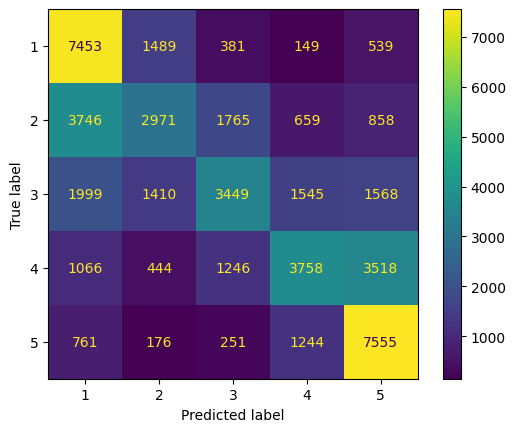

In [56]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=2500, stop_words=stopwords.words('english'))

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_naives(texto_features)

### Representacion 2


              precision    recall  f1-score   support

           1     0.4984    0.7478    0.5981     10011
           2     0.4614    0.3020    0.3651      9999
           3     0.4886    0.3470    0.4058      9971
           4     0.5115    0.3726    0.4311     10032
           5     0.5399    0.7593    0.6311      9987

    accuracy                         0.5057     50000
   macro avg     0.5000    0.5057    0.4862     50000
weighted avg     0.5000    0.5057    0.4862     50000



MultinomialNB()

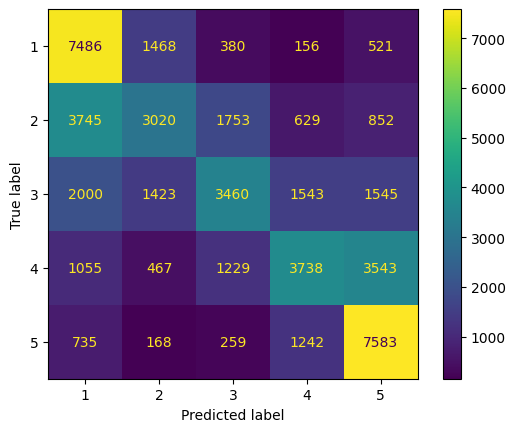

In [57]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=5000, stop_words=stopwords.words('english'))

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_naives(texto_features)

### Representacion 3


              precision    recall  f1-score   support

           1     0.4988    0.7484    0.5986     10011
           2     0.4573    0.3009    0.3630      9999
           3     0.4885    0.3469    0.4057      9971
           4     0.5131    0.3715    0.4310     10032
           5     0.5395    0.7593    0.6308      9987

    accuracy                         0.5054     50000
   macro avg     0.4994    0.5054    0.4858     50000
weighted avg     0.4994    0.5054    0.4858     50000



MultinomialNB()

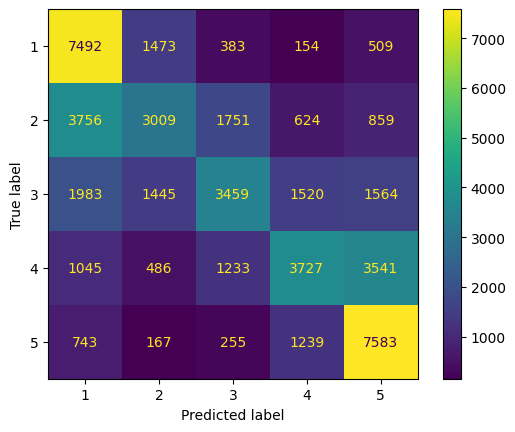

In [58]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=6500, stop_words=stopwords.words('english'))

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_naives(texto_features)

## Logistic Regresion (SDGClassfier)

In [59]:
from sklearn.linear_model import SGDClassifier

In [60]:
def create_model_sdg(texto_features, eta = 0.1):
    # Partición del dataset: Seleccionar 80% para entrenamiento, 20% pruebas.
    X_train, X_test, y_train, y_test = train_test_split(
        texto_features, labels, test_size=0.2, random_state=0)

    # Modelo: Naive Bayes
    # investicar los parámetros en la documentacion y variar el learning_rate
    model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=eta)
    model.fit(X_train, y_train)

    # Reporte de clasificación
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    return model

### Representacion 1

              precision    recall  f1-score   support

           1     0.5803    0.5260    0.5518     10011
           2     0.4060    0.3331    0.3660      9999
           3     0.3869    0.3429    0.3636      9971
           4     0.3758    0.5775    0.4553     10032
           5     0.6428    0.5451    0.5899      9987

    accuracy                         0.4651     50000
   macro avg     0.4784    0.4649    0.4653     50000
weighted avg     0.4783    0.4651    0.4654     50000



SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss')

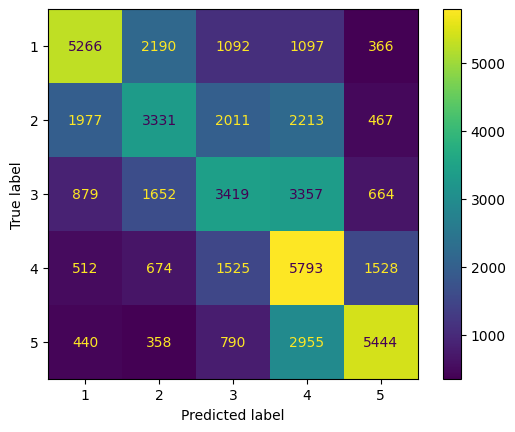

In [61]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=2500, stop_words=stopwords.words('english'))
# max_features representa el tamaño del vocabulario. Vamos a permitir 2500 palabras.
# stop_words le indicamos las palabras de parada para que las ignore en el vocabulario.

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_sdg(texto_features,eta=0.1)

### Representacion 2

              precision    recall  f1-score   support

           1     0.6113    0.4986    0.5492     10011
           2     0.3638    0.3712    0.3675      9999
           3     0.3400    0.3887    0.3627      9971
           4     0.4136    0.4078    0.4107     10032
           5     0.5861    0.6068    0.5963      9987

    accuracy                         0.4546     50000
   macro avg     0.4629    0.4546    0.4573     50000
weighted avg     0.4630    0.4546    0.4573     50000



SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss')

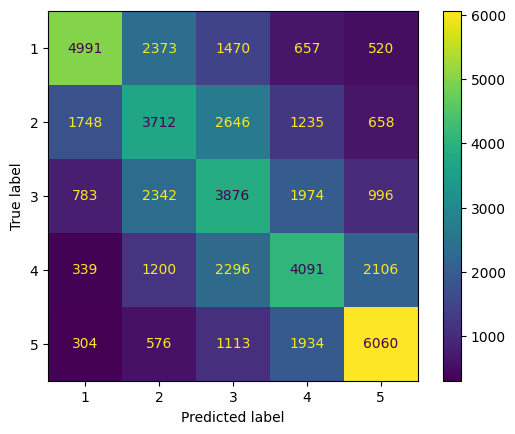

In [62]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=4500, stop_words=stopwords.words('english'))
# max_features representa el tamaño del vocabulario. Vamos a permitir 2500 palabras.
# stop_words le indicamos las palabras de parada para que las ignore en el vocabulario.

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_sdg(texto_features,eta=0.1)

### Representacion 3

              precision    recall  f1-score   support

           1     0.6272    0.5145    0.5653     10011
           2     0.4013    0.3844    0.3927      9999
           3     0.4304    0.3449    0.3829      9971
           4     0.4067    0.3674    0.3860     10032
           5     0.4903    0.7439    0.5910      9987

    accuracy                         0.4710     50000
   macro avg     0.4712    0.4710    0.4636     50000
weighted avg     0.4712    0.4710    0.4636     50000



SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss')

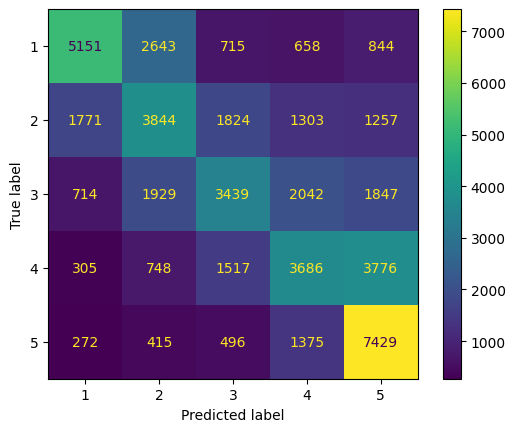

In [63]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=6500, stop_words=stopwords.words('english'))
# max_features representa el tamaño del vocabulario. Vamos a permitir 2500 palabras.
# stop_words le indicamos las palabras de parada para que las ignore en el vocabulario.

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_sdg(texto_features,eta=0.1)

## Neuronal Network (Sequencial)

In [64]:
from keras.models import Sequential

### Representacion 1

### Representacion 2

### Representacion 3